# Lecture 4

In [ ]:
!pip install nlpia

In [1]:
import numpy as np

### 4.1.3 Thought experiment

In [2]:
topic = {}
tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6)))) 

This `tfidf` vector is just a random example, as if it were computed for a single document that contained these words in some random proportion.

In [5]:
tfidf

{'cat': 0.30743560800316083,
 'dog': 0.5168671642929766,
 'apple': 0.5555888696205626,
 'lion': 0.07329871754506678,
 'NYC': 0.38247893571977465,
 'love': 0.7274697256234035}

In [4]:
topic['pet'] = (  .3 * tfidf['cat'] 
                + .3 * tfidf['dog'] 
                + 0 * tfidf['apple']
                + 0 * tfidf['lion'] 
                - .2 * tfidf['NYC'] 
                + .2 * tfidf['love'])

topic['animal'] = (.1 * tfidf['cat'] 
                   + .1 * tfidf['dog'] 
                   - .1 * tfidf['apple']
                   + .5 * tfidf['lion'] 
                   + .1 * tfidf['NYC'] 
                   - .1 * tfidf['love'])

topic['city'] = (0 * tfidf['cat'] 
                 - .1 * tfidf['dog'] 
                 + .2 * tfidf['apple']
                 - .1 * tfidf['lion'] 
                 + .5 * tfidf['NYC'] 
                 + .1 * tfidf['love'])

*Hand-crafted* weights (.3, .3, 0, 0, -.2, .2) are multiplied by imaginary tfidf values to create topic vectors for your imaginary random document.

In [6]:
topic

{'pet': 0.316288989669567,
 'animal': 0.029021670049728,
 'city': 0.3160876261625359}

$\begin{bmatrix}
.3 & .3& 0& 0& -.2& .2\\
.1 &.1 &-.1& .5& .1 &-.1\\
0 &-.1& .2& -.1& .5 &.1\\
\end{bmatrix}$
$\begin{bmatrix}
\text{cat} \\ 
\text{dog} \\ 
\text{apple} \\ 
\text{lion} \\ 
\text{NYC} \\ 
\text{love} \\ 
\end{bmatrix}=
\begin{bmatrix}
\text{pet}\\
\text{animal}\\
\text{city}\\
\end{bmatrix}
$

**Go back to the slide.**

Topic to word? No problem, but the same problem still there.

How to assign the weights?

In [7]:
word_vector = {}
word_vector['cat'] = .3 * topic['pet'] + .1 * topic['animal'] + 0 * topic['city']
word_vector['dog'] = .3 * topic['pet'] + .1 * topic['animal'] - .1 * topic['city']
word_vector['apple'] = 0 * topic['pet'] - .1 * topic['animal'] + .2 * topic['city']
word_vector['lion'] = 0 * topic['pet'] + .5 * topic['animal'] - .1 * topic['city']
word_vector['NYC'] = -.2 * topic['pet'] + .1 * topic['animal'] + .5 * topic['city']
word_vector['love'] = .2 * topic['pet'] - .1 * topic['animal'] + .1 * topic['city']
word_vector

{'cat': 0.09778886390584289,
 'dog': 0.0661801012895893,
 'apple': 0.06031535822753438,
 'lion': -0.01709792759138959,
 'NYC': 0.09768818215232734,
 'love': 0.09196439354519419}

### 4.1.5 An LDA classifier

In [2]:
import pandas as pd
from nlpia.data.loaders import get_data
pd.options.display.width = 120
sms = get_data('sms-spam')

2023-04-08 13:13:23.929027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/pugnlp/tutil.py:100: FutureWarning: The pand

In [3]:
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)] 
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)

In [6]:
sms.head()

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
sms['spam'] = sms.spam.astype(int)

In [7]:
len(sms)

4837

In [8]:
sms.spam.sum()

638

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

In [10]:
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)

In [11]:
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
tfidf_docs.shape

(4837, 9232)

In [13]:
mask = sms.spam.astype(bool).values

In [14]:
spam_centroid = tfidf_docs[mask].mean(axis=0)
ham_centroid = tfidf_docs[~mask].mean(axis=0)

In [15]:
spam_centroid.round(2)

array([0.06, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])

In [16]:
spam_centroid.shape

(9232,)

In [17]:
ham_centroid.round(2)

array([0.02, 0.01, 0.  , ..., 0.  , 0.  , 0.  ])

In [18]:
ham_centroid.shape

(9232,)

Consider the following code

In [20]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)

In [21]:
print(spamminess_score.round(2))
print(spamminess_score.shape)

[-0.01 -0.02  0.04 ... -0.01 -0.    0.  ]
(4837,)


In [23]:
from sklearn.preprocessing import MinMaxScaler
# Why do we need `MinMaxCaler`?
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))

In [24]:
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))

In [25]:
sms['lda_predict'] = (sms.lda_score > .5).astype(int)
sms.head()

,spam,text,lda_score,lda_predict
sms0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0
sms1,0,Ok lar... Joking wif u oni...,0.177888,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1
sms3,0,U dun say so early hor... U c already then say...,0.184565,0
sms4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0


In [26]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(sms.spam, sms.lda_predict)

array([[4135,   64],
       [  45,  593]])

Interpret **confusion matrix** above.

In [31]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(sms.spam, sms.lda_predict))
print(recall_score(sms.spam, sms.lda_predict))

0.9025875190258752
0.9294670846394985


### 2-dimensional plot

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, ' y')

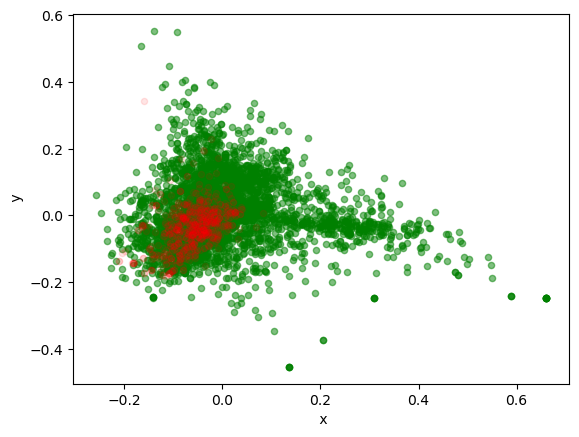

In [29]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn
pca_model = PCA(n_components=3)
tfidf_docs_3d = pca_model.fit_transform(tfidf_docs)
df = pd.DataFrame(tfidf_docs_3d)
ax = df[~mask].plot(x=0, y=1, kind='scatter', alpha=.5, c='green')
df[mask].plot(x=0, y=1, ax=ax, alpha=.1, kind='scatter', c='red')
plt.xlabel(' x')
plt.ylabel(' y')

### 3-dimensional plot

In [30]:
import plotly as py
spam_trace = dict(
        x=df[0][mask], y=df[1][mask], z=df[2][mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='red', line=dict(width=0)) 
    )
ham_trace = dict(
        x=df[0][~mask], y=df[1][~mask], z=df[2][~mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='green', line=dict(width=0)) 
    )
fig = dict(data=[ham_trace, spam_trace], layout={'title': 'LDA Spamminess Model'})
py.offline.plot(fig, filename='lda_spam_3d_scatter.html')

'lda_spam_3d_scatter.html'

### Optional: Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB

In [34]:
nb = MultinomialNB()
nb.fit(tfidf_docs, sms.spam > 0) 

MultinomialNB()

In [36]:
sms['nb_predict'] = nb.predict(tfidf_docs).astype(int)

In [38]:
sms.head()

,spam,text,lda_score,lda_predict,nb_predict
sms0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0,0
sms1,0,Ok lar... Joking wif u oni...,0.177888,0,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1,1
sms3,0,U dun say so early hor... U c already then say...,0.184565,0,0
sms4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0,0


In [39]:
confusion_matrix(sms.spam, sms.nb_predict)

array([[4199,    0],
       [ 162,  476]])

In [40]:
print(precision_score(sms.spam, sms.nb_predict))
print(recall_score(sms.spam, sms.nb_predict))

1.0
0.7460815047021944


# PCA in practice

For now remember one thing: want to reduce the dimensionality of the data

In [46]:
np.random.seed(123)

m = 300
X = np.random.rand(m,10)

1. We have a 300X10 simulated data

In [48]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9
0,0.696469,0.286139,0.226851,0.551315,0.719469,0.423106,0.980764,0.684830,0.480932,0.392118
1,0.343178,0.729050,0.438572,0.059678,0.398044,0.737995,0.182492,0.175452,0.531551,0.531828
2,0.634401,0.849432,0.724455,0.611024,0.722443,0.322959,0.361789,0.228263,0.293714,0.630976
3,0.092105,0.433701,0.430863,0.493685,0.425830,0.312261,0.426351,0.893389,0.944160,0.501837
4,0.623953,0.115618,0.317285,0.414826,0.866309,0.250455,0.483034,0.985560,0.519485,0.612895
...,...,...,...,...,...,...,...,...,...,...
295,0.550655,0.832068,0.159499,0.501746,0.409219,0.866386,0.130992,0.891755,0.250271,0.605698
296,0.379898,0.932743,0.197528,0.502540,0.228289,0.801227,0.271054,0.953488,0.924399,0.475190
297,0.012931,0.965418,0.685964,0.491979,0.604086,0.110986,0.157537,0.638912,0.048961,0.702302
298,0.919779,0.708955,0.560634,0.794203,0.748466,0.590660,0.197023,0.007832,0.457306,0.241041


2. Want to reduce its dimension into 4
3. Let's apply PCA algorithm

In [49]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA(n_components=4)
pd.DataFrame(pca.fit_transform(X))

,0,1,2,3
0,0.090578,0.104127,-0.091350,0.186923
1,-0.104959,-0.134492,-0.097900,-0.284122
2,-0.112327,0.138374,0.191988,-0.416827
3,-0.267881,-0.399074,-0.104800,0.347126
4,-0.231994,-0.173174,0.009272,0.457337
...,...,...,...,...
295,0.347822,-0.656376,0.123467,-0.148638
296,0.200358,-0.751030,0.022448,-0.021412
297,-0.245635,-0.393486,-0.121678,-0.366078
298,-0.151527,0.274781,0.511113,-0.482412


- Note that the column name does not mean anything. 
- Column `0` here is **different** from the column `0` in the original data. 
    - It is just an index
- In fact, the resulting columns are called `principal component` (PC).
    - The first column is the first PC, the second column is the second PC,...
    - The order matters here

4. Evaluate the resulting data

In [54]:
pca.explained_variance_ratio_

array([0.13859994, 0.12407102, 0.11135165, 0.10492685])

- This output tells us that about 14% of the dataset’s variance lies along the first PC, and about 12% lies along the second PC. Overall, the first four PC explains 48 % of the dataset's variance
    - More PCs explain more variance
- It would not be surprising, given that the data set is just randomly generated.


In [55]:
pca = PCA()
pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.13859994 0.12407102 0.11135165 0.10492685 0.09896576 0.0966074
 0.08809271 0.08488608 0.08119078 0.07130782]
1.0


# MNIST dataset example

In [56]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.



In [58]:
from IPython.display import Image
Image(url = 'https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0302.png', width = 500)

In [59]:
X_train.shape

(60000, 784)

In [60]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

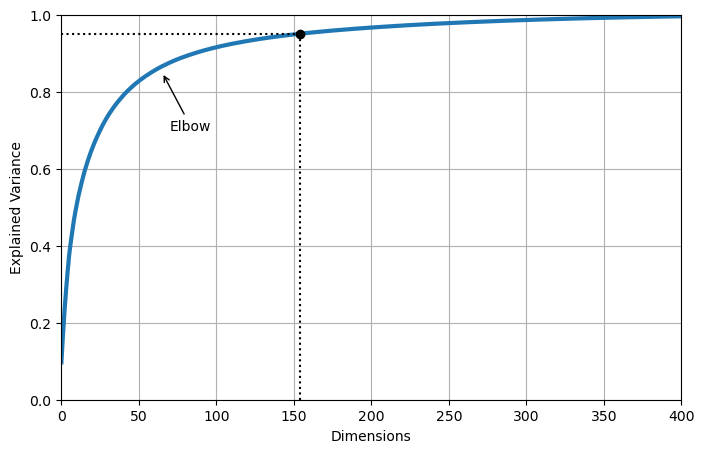

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

- We reduce the data dimension more than half and the resulting data still explains more than 90 % variance
- Consider the property of the data when PCA algorithm works well

`PCA`, `SVD`, and Latent Semantic Analysis (`LSA`) are all the same.

- You are more likely to work with PCA here
    - Don't bother the memory
- When you apply PCA to the text data, it is called LSA

Still, remember that we are making the dimensionality reduction. Don't attach any meaning yet.

Now, let's apply PCA to the sms spam classification data

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

In [65]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [70]:
tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs.head()

,0,1,2,3,4,5,6,7,8,9,...,9222,9223,9224,9225,9226,9227,9228,9229,9230,9231
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102819,0.131375,0.126752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
len(tfidf.vocabulary_)

9232

In [68]:
from sklearn.decomposition import PCA

Consider how many PC do we need? It is purely data-driven.

In [77]:
pca = PCA(n_components=0.9) # select PCs explaining 90 % variance
pca.fit(tfidf_docs)

PCA(n_components=0.9)

In [79]:
len(pca.explained_variance_ratio_)

1874

In [80]:
pca = PCA(n_components=16)
pca.fit(tfidf_docs)
print(pca.explained_variance_ratio_.sum())

0.101192494543766


In [81]:
pca_topic_vectors = pca.transform(tfidf_docs)
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns,index=index)
pca_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.013,-0.082,0.011,-0.003,0.002,-0.037,-0.012,0.035
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.065,0.023,-0.024,-0.005,0.032,0.043,-0.024,0.050,-0.045
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.000,-0.057,0.049,0.123,0.018,0.023,-0.019,-0.038,0.058
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.165,-0.074,0.062,-0.107,0.023,0.022,0.071,-0.053,0.018,-0.078
sms4,0.002,0.031,0.038,0.034,-0.075,-0.092,-0.044,0.061,-0.044,0.028,0.027,-0.011,0.024,0.033,-0.088,-0.017
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,0.005,0.167,-0.023,0.064,0.043,0.058,-0.025,0.075,0.001,0.016


In [82]:
pca_topic_vectors.shape

(4837, 16)

**Let's go back to the slide**

## SVD 

Remember PCA

In [85]:
np.random.seed(123)

m = 300
X = np.random.rand(m,10)

In [86]:
pca = PCA(n_components=4)
pd.DataFrame(pca.fit_transform(X))

,0,1,2,3
0,0.090578,0.104127,-0.091350,0.186923
1,-0.104959,-0.134492,-0.097900,-0.284122
2,-0.112327,0.138374,0.191988,-0.416827
3,-0.267881,-0.399074,-0.104800,0.347126
4,-0.231994,-0.173174,0.009272,0.457337
...,...,...,...,...
295,0.347822,-0.656376,0.123467,-0.148638
296,0.200358,-0.751030,0.022448,-0.021412
297,-0.245635,-0.393486,-0.121678,-0.366078
298,-0.151527,0.274781,0.511113,-0.482412


SVD uses NumPy's `svd()` function

In [88]:
X_centered = X - X.mean(axis=0) # centering
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]
c3 = Vt[2]
c4 = Vt[3]

Note that PCA assumes that the dataset is centered around the origin. 

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first *d* principal components

Projecting the data down to *d* dimensions
$$X_{d-\text{proj}}=XW_d$$

Since we select 4 PCs in the example above

In [90]:
W4 = Vt[:4].T
X4D = X_centered @ W4

In [92]:
pd.DataFrame(X4D)

,0,1,2,3
0,-0.090578,0.104127,0.091350,-0.186923
1,0.104959,-0.134492,0.097900,0.284122
2,0.112327,0.138374,-0.191988,0.416827
3,0.267881,-0.399074,0.104800,-0.347126
4,0.231994,-0.173174,-0.009272,-0.457337
...,...,...,...,...
295,-0.347822,-0.656376,-0.123467,0.148638
296,-0.200358,-0.751030,-0.022448,0.021412
297,0.245635,-0.393486,0.121678,0.366078
298,0.151527,0.274781,-0.511113,0.482412


In [93]:
# PCA example
pd.DataFrame(pca.fit_transform(X))

,0,1,2,3
0,0.090578,0.104127,-0.091350,0.186923
1,-0.104959,-0.134492,-0.097900,-0.284122
2,-0.112327,0.138374,0.191988,-0.416827
3,-0.267881,-0.399074,-0.104800,0.347126
4,-0.231994,-0.173174,0.009272,0.457337
...,...,...,...,...
295,0.347822,-0.656376,0.123467,-0.148638
296,0.200358,-0.751030,0.022448,-0.021412
297,-0.245635,-0.393486,-0.121678,-0.366078
298,-0.151527,0.274781,0.511113,-0.482412


## Example in 4.3

In [94]:
from nlpia.book.examples.ch04_catdog_lsa_sorted import lsa_models, prettify_tdm

100%|██████████| 263/263 [00:00<00:00, 261957.24it/s]


In [95]:
bow_svd, tfidf_svd = lsa_models()

100%|██████████| 263/263 [00:00<00:00, 183513.88it/s]


In [96]:
prettify_tdm(**bow_svd)

,cat,dog,apple,lion,nyc,love,text
0,,,1,,1,,NYC is the Big Apple.
1,,,1,,1,,NYC is known as the Big Apple.
2,,,,,1,1,I love NYC!
3,,,1,,1,,I wore a hat to the Big Apple party in NYC.
4,,,1,,1,,Come to NYC. See the Big Apple!
5,,,1,,,,Manhattan is called the Big Apple.
6,1,,,,,,New York is a big city for a small cat.
7,1,,,1,,,"The lion, a big cat, is the king of the jungle."
8,1,,,,,1,I love my pet cat.
9,,,,,1,1,I love New York City (NYC).


In [97]:
tdm = bow_svd['tdm']

In [100]:
df = tdm.T
df

,cat,dog,apple,lion,nyc,love
0,0,0,1,0,1,0
1,0,0,1,0,1,0
2,0,0,0,0,1,1
3,0,0,1,0,1,0
4,0,0,1,0,1,0
5,0,0,1,0,0,0
6,1,0,0,0,0,0
7,1,0,0,1,0,0
8,1,0,0,0,0,1
9,0,0,0,0,1,1


In [101]:
pca = PCA()
pca.fit(df)

PCA()

In [102]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

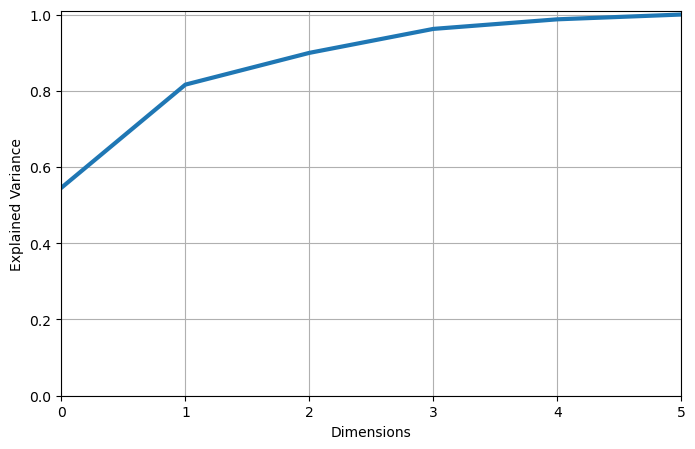

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 5, 0, 1.01])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

In [106]:
pca = PCA(n_components=2)
pca.fit_transform(df)

array([[-0.81144222, -0.23437017],
       [-0.81144222, -0.23437017],
       [-0.18699845,  1.01545489],
       [-0.81144222, -0.23437017],
       [-0.81144222, -0.23437017],
       [-0.25859671, -0.57119021],
       [ 0.86896467, -0.26732958],
       [ 1.02560494, -0.38633682],
       [ 0.95818795,  0.51776432],
       [-0.18699845,  1.01545489],
       [ 1.02560494, -0.38633682]])

## LSA + LDA = spam classifier

Come back to sms data

In [109]:
sms.head()

,spam,text,lda_score,lda_predict,nb_predict
sms0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0,0
sms1,0,Ok lar... Joking wif u oni...,0.177888,0,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1,1
sms3,0,U dun say so early hor... U c already then say...,0.184565,0,0
sms4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0,0


In [111]:
tfidf_docs.head()

,0,1,2,3,4,5,6,7,...,9224,9225,9226,9227,9228,9229,9230,9231
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
pca_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.013,-0.082,0.011,-0.003,0.002,-0.037,-0.012,0.035
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.065,0.023,-0.024,-0.005,0.032,0.043,-0.024,0.050,-0.045
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.000,-0.057,0.049,0.123,0.018,0.023,-0.019,-0.038,0.058
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.165,-0.074,0.062,-0.107,0.023,0.022,0.071,-0.053,0.018,-0.078
sms4,0.002,0.031,0.038,0.034,-0.075,-0.092,-0.044,0.061,-0.044,0.028,0.027,-0.011,0.024,0.033,-0.088,-0.017
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,0.005,0.167,-0.023,0.064,0.043,0.058,-0.025,0.075,0.001,0.016


Let’s see how these LSA topics are at predicting something useful, such as spaminess. You’ll use your LSA topic vectors to train an LDA model again (like you did with your PCA topic vectors):

In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 1)
lda.fit(pca_topic_vectors, sms.spam)

LinearDiscriminantAnalysis(n_components=1)

In [114]:
sms['ldia16_spam'] = lda.predict(pca_topic_vectors)

In [115]:
sms.head()

,spam,text,lda_score,lda_predict,nb_predict,ldia16_spam
sms0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0,0,0
sms1,0,Ok lar... Joking wif u oni...,0.177888,0,0,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1,1,1
sms3,0,U dun say so early hor... U c already then say...,0.184565,0,0,0
sms4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0,0,0


In [116]:
confusion_matrix(sms.spam, sms.ldia16_spam)

array([[4135,   64],
       [ 142,  496]])

In [117]:
print(precision_score(sms.spam, sms.ldia16_spam))
print(recall_score(sms.spam, sms.ldia16_spam))

0.8857142857142857
0.7774294670846394
